In [32]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2 as cv
from sklearn.model_selection import train_test_split
import time
import os
from sklearn.utils import shuffle
from IPython.display import clear_output

In [33]:
# Importing the list of filepath and image metadata (Manually Annotated part 1):
file_list1 = pd.read_csv('/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_file_lists/training.csv')

# Importing the list of filepath and image metadata (Manually Annotated part 2):
file_list2 = pd.read_csv('/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_file_lists/validation.csv')

In [34]:
file_list = pd.concat([file_list1,file_list2]).reset_index(drop = True)

In [35]:
file_list.head(3)

,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal
0,689/737db2483489148d783ef278f43f486c0a97e140fc...,134,134,899,899,181.64;530.91;188.32;627.82;195.1;723.37;205.2...,1,0.785714,-0.055556
1,392/c4db2f9b7e4b422d14b6e038f0cdc3ecee239b5532...,20,20,137,137,28.82;77.52;29.12;93.25;31.04;108.51;33.03;123...,0,-0.017253,0.004313
2,468/21772b68dc8c2a11678c8739eca33adb6ccc658600...,11,11,176,176,30.52;87.33;32.55;106.43;36.94;125.81;43.06;14...,0,0.174603,0.007937


In [36]:
# Drop a corrupted file:
file_list[file_list['subDirectory_filePath'] == '103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']

,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal
235929,103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67...,0,0,161,161,8.17;60.0;10.92;81.3;13.7;101.4;17.72;120.78;2...,10,-2.0,-2.0


In [37]:
file_list = file_list.drop(235929)

In [38]:
file_list.shape

(420298, 9)

In [39]:
expression_classes = pd.DataFrame([[0, 'Neutral'], [1, 'Happiness'], [2, 'Sadness'], [3, 'Surprise'], [4, 'Fear'], 
                                   [5, 'Disgust'], [6, 'Anger'], [7, 'Contempt'], [8, 'None'], 
                                   [9, 'Uncertain'], [10, 'No-Face']], 
                                  columns = ['code', 'expression name'])
expression_classes

,code,expression name
0,0,Neutral
1,1,Happiness
2,2,Sadness
3,3,Surprise
4,4,Fear
5,5,Disgust
6,6,Anger
7,7,Contempt
8,8,None
9,9,Uncertain


In [40]:
file_list.groupby('expression').count()\
    .join(expression_classes)\
        .loc[:,['subDirectory_filePath', 'expression name']]\
            .sort_values('subDirectory_filePath', ascending = False)

,subDirectory_filePath,expression name
expression,,
1,134915,Happiness
10,82914,No-Face
0,75374,Neutral
8,33588,None
2,25959,Sadness
6,25382,Anger
3,14590,Surprise
9,12145,Uncertain
4,6878,Fear


In [41]:
file_list_filtered = file_list[file_list['expression'].isin([1,2])].reset_index(drop = True)

In [42]:
file_list_filtered.groupby('expression').count()\
    .join(expression_classes)\
        .loc[:,['subDirectory_filePath', 'expression name']]\
            .sort_values('subDirectory_filePath', ascending = False)

,subDirectory_filePath,expression name
expression,,
1,134915,Happiness
2,25959,Sadness


Labelled as: Happiness
Shape:  (992, 992, 3)


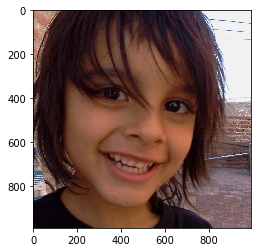

In [10]:
index = 223

root_dir = '/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_compressed/Manually Annotated Images/'
sample_image = cv.imread(root_dir + file_list_filtered['subDirectory_filePath'][index])
plt.imshow(cv.cvtColor(sample_image, cv.COLOR_BGR2RGB));
print('Labelled as: '+ expression_classes.loc[file_list_filtered['expression'][index], 'expression name'])
print('Shape: ', sample_image.shape)

In [11]:
file_list_filtered.head(3)

,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal
0,689/737db2483489148d783ef278f43f486c0a97e140fc...,134,134,899,899,181.64;530.91;188.32;627.82;195.1;723.37;205.2...,1,0.785714,-0.055556
1,944/06e9ae8d3b240eb68fa60534783eacafce2def60a8...,40,40,269,269,44.43;158.17;47.08;189.2;50.54;221.88;58.3;253...,1,0.153401,0.038890
2,981/5c991a28b5550cf5e1e830d5eed1dc7f80581462d6...,35,35,236,236,46.5;134.89;47.28;158.87;51.45;182.31;58.37;20...,1,0.547918,0.249054


In [13]:
#sample_Neutral = file_list_filtered[file_list_filtered['expression'] == 0].sample(10000)
sample_Happiness = file_list_filtered[file_list_filtered['expression'] == 1].sample(10000)
sample_Sadness = file_list_filtered[file_list_filtered['expression'] == 2].sample(10000)
#sample_Anger = file_list_filtered[file_list_filtered['expression'] == 6].sample(10000)

#sample_list = shuffle(pd.concat([sample_Neutral, sample_Happiness, sample_Sadness, sample_Anger])).reset_index()
sample_list = shuffle(pd.concat([sample_Happiness, sample_Sadness])).reset_index()

In [15]:
sample_list.head(3)

,index,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal
0,36359,736/e3a46711c4a6c01cb6dc092be83081e41711c6cda8...,152,152,1019,1019,296.68;512.12;290.69;617.4;293.65;728.58;305.5...,1,0.682540,-0.015873
1,160370,918/725640e7fbd1534dc9d19e7b87c6ae86d60648012c...,21,21,141,141,21.4;79.15;20.67;95.31;21.6;112.49;24.08;128.2...,1,0.667828,0.053233
2,144638,485/523daa172b5ca4f6a0de3980b15d40159452c9bee6...,38,38,256,256,35.01;132.03;37.29;164.4;44.8;196.87;52.59;225...,2,-0.904956,-0.169377


In [ ]:
root_dir = '/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_compressed/Manually Annotated Images/'
images = []

counter = 0

for filepath in sample_list['subDirectory_filePath']:
    im = cv.imread(root_dir + filepath)
    
    if len(im.shape) == 3:        # Converting to greyscale
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    if im.shape != (100, 100):    # Resizing to 100 x 100
        im = cv.resize(im, (100, 100))

    images.append(im)
    counter += 1
    if counter % 1000 ==0:
        clear_output(wait = True)
        print(f'Image {counter} processed')
    
images = np.asarray(images)

In [66]:
expressions = sample_list['expression']

In [35]:
np.save('sample_images_happy_sad_20000.npy', images)
np.save('sample_expressions_happy_sad_20000.npy', expressions)

In [17]:
images = np.load('sample_images_happy_sad_20000.npy')
expressions = np.load('sample_expressions_happy_sad_20000.npy')

Labelled as: Happiness
Shape:  (100, 100)


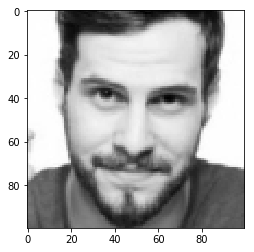

In [34]:
index = 9897

plt.imshow(images[index], cmap = 'gray');
print('Labelled as: '+ expression_classes.loc[expressions[index], 'expression name'])
print('Shape: ', images[index].shape)

In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

def random_mini_batches(X, Y, mini_batch_size = 100, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (m, Hi, Wi, Ci)
    Y -- true "label" vector of shape (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- random seed value.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches



def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction



def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, (None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, (None, n_y))
    
    return X, Y

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              
        
    W1 = tf.get_variable("W1", [4, 4, 1, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 3, activation_fn=None)

    return Z3

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (4, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 50, minibatch_size = 100, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 4)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 4)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 2 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [41]:
X_train, X_test, y_train, y_test = train_test_split(images, expressions, 
                                                    test_size=0.1, random_state=1, stratify = expressions)

X_train, X_test, y_train, y_test = X_train/255, X_test/255, y_train/255, y_test/255

X_train_CNN = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_test_CNN = X_test.reshape(X_test.shape[0], 100, 100, 1)
y_train_CNN = np.asarray(pd.get_dummies(y_train))
y_test_CNN = np.asarray(pd.get_dummies(y_test))

Cost after epoch 0: 0.645637
Cost after epoch 2: 0.413915
Cost after epoch 4: 0.363859
Cost after epoch 6: 0.335726
Cost after epoch 8: 0.319417
Cost after epoch 10: 0.304812
Cost after epoch 12: 0.296800
Cost after epoch 14: 0.291825
Cost after epoch 16: 0.280060
Cost after epoch 18: 0.273995


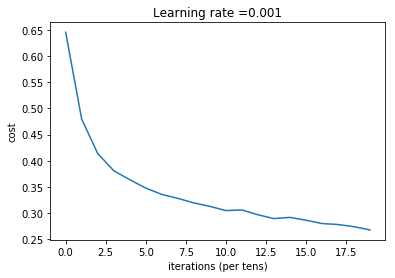

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.88722223
Test Accuracy: 0.857


In [45]:
# With learning_rate = 0.001, num_epochs = 20, minibatch_size = 100
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)

Cost after epoch 0: 0.645637
Cost after epoch 2: 0.413915
Cost after epoch 4: 0.363859
Cost after epoch 6: 0.335726
Cost after epoch 8: 0.319417
Cost after epoch 10: 0.304812
Cost after epoch 12: 0.296800
Cost after epoch 14: 0.291825
Cost after epoch 16: 0.280060
Cost after epoch 18: 0.273995
Cost after epoch 20: 0.267799
Cost after epoch 22: 0.263054
Cost after epoch 24: 0.255528
Cost after epoch 26: 0.250371
Cost after epoch 28: 0.246642
Cost after epoch 30: 0.244370
Cost after epoch 32: 0.239628
Cost after epoch 34: 0.233860
Cost after epoch 36: 0.230624
Cost after epoch 38: 0.229043


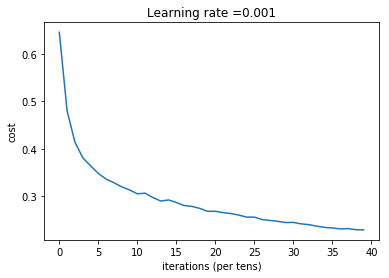

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.90088886
Test Accuracy: 0.864


In [55]:
# With learning_rate = 0.001, num_epochs = 40, minibatch_size = 100
start = time.time()
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()

In [61]:
print(f'Training time: {((end-start)/60):0.3} min')

Training time: 25.6 min


Cost after epoch 0: 0.645637
Cost after epoch 2: 0.413915
Cost after epoch 4: 0.363859
Cost after epoch 6: 0.335726
Cost after epoch 8: 0.319417
Cost after epoch 10: 0.304812
Cost after epoch 12: 0.296800
Cost after epoch 14: 0.291825
Cost after epoch 16: 0.280060
Cost after epoch 18: 0.273995
Cost after epoch 20: 0.267799
Cost after epoch 22: 0.263054
Cost after epoch 24: 0.255528
Cost after epoch 26: 0.250371
Cost after epoch 28: 0.246642
Cost after epoch 30: 0.244370
Cost after epoch 32: 0.239628
Cost after epoch 34: 0.233860
Cost after epoch 36: 0.230624
Cost after epoch 38: 0.229043
Cost after epoch 40: 0.225432
Cost after epoch 42: 0.225191
Cost after epoch 44: 0.221195
Cost after epoch 46: 0.217818
Cost after epoch 48: 0.221650
Cost after epoch 50: 0.213340
Cost after epoch 52: 0.211846
Cost after epoch 54: 0.207401
Cost after epoch 56: 0.205131
Cost after epoch 58: 0.204884
Cost after epoch 60: 0.203312
Cost after epoch 62: 0.201462
Cost after epoch 64: 0.197219
Cost after epoc

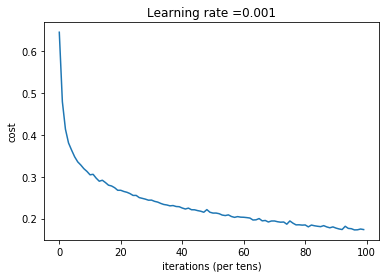

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9407222
Test Accuracy: 0.8555


In [64]:
# With learning_rate = 0.001, num_epochs = 100, minibatch_size = 100
start = time.time()
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()

In [65]:
print(f'Training time: {((end-start)/60):0.3} min')

Training time: 62.7 min


In [43]:
# With 3 expressions:
file_list_filtered = file_list[file_list['expression'].isin([1,2, 10])].reset_index(drop = True)
sample_NoFace = file_list_filtered[file_list_filtered['expression'] == 10].sample(10000)
sample_Happiness = file_list_filtered[file_list_filtered['expression'] == 1].sample(10000)
sample_Sadness = file_list_filtered[file_list_filtered['expression'] == 2].sample(10000)

sample_list = shuffle(pd.concat([sample_NoFace, sample_Happiness, sample_Sadness])).reset_index()

root_dir = '/Volumes/Arash External Drive/AffectNet Data/Manually_Annotated_compressed/Manually Annotated Images/'
images = []

counter = 0

for filepath in sample_list['subDirectory_filePath']:
    im = cv.imread(root_dir + filepath)
    
    if len(im.shape) == 3:        # Converting to greyscale
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    if im.shape != (100, 100):    # Resizing to 100 x 100
        im = cv.resize(im, (100, 100))

    images.append(im)
    counter += 1
    if counter % 1000 ==0:
        clear_output(wait = True)
        print(f'Image {counter} processed')
    
images = np.asarray(images)

expressions = sample_list['expression']

Image 30000 processed


In [44]:
np.save('sample_images_happy_sad_noface_10000each.npy', images)
np.save('sample_expressions_happy_sad_noface_10000each.npy', expressions)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(images, expressions, 
                                                    test_size=0.1, random_state=1, stratify = expressions)

X_train, X_test, y_train, y_test = X_train/255, X_test/255, y_train/255, y_test/255

X_train_CNN = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_test_CNN = X_test.reshape(X_test.shape[0], 100, 100, 1)
y_train_CNN = np.asarray(pd.get_dummies(y_train))
y_test_CNN = np.asarray(pd.get_dummies(y_test))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.026665
Cost after epoch 2: 0.830532
Cost after epoch 4: 0.775392
Cost after epoch 6: 0.738116
Cost after epoch 8: 0.721058
Cost after epoch 10: 0.694487
Cost after epoch 12: 0.679098
Cost after epoch 14: 0.669616
Cost after epoch 16: 0.659589
Cost after epoch 18: 0.652378


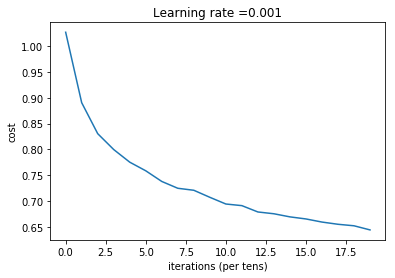

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.7320741
Test Accuracy: 0.692


In [47]:
# With learning_rate = 0.001, num_epochs = 20, minibatch_size = 100
start = time.time()
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()

Cost after epoch 0: 1.026665
Cost after epoch 2: 0.830532
Cost after epoch 4: 0.775392
Cost after epoch 6: 0.738116
Cost after epoch 8: 0.721058
Cost after epoch 10: 0.694487
Cost after epoch 12: 0.679098
Cost after epoch 14: 0.669616
Cost after epoch 16: 0.659589
Cost after epoch 18: 0.652378
Cost after epoch 20: 0.638646
Cost after epoch 22: 0.631264
Cost after epoch 24: 0.630462
Cost after epoch 26: 0.618659
Cost after epoch 28: 0.610942
Cost after epoch 30: 0.604370
Cost after epoch 32: 0.600387
Cost after epoch 34: 0.598679
Cost after epoch 36: 0.593229
Cost after epoch 38: 0.594727
Cost after epoch 40: 0.586769
Cost after epoch 42: 0.584483
Cost after epoch 44: 0.576087
Cost after epoch 46: 0.574923
Cost after epoch 48: 0.568158


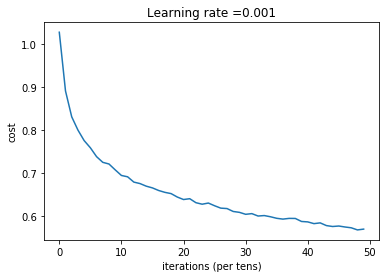

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.772037
Test Accuracy: 0.70166665


In [49]:
# With learning_rate = 0.001, num_epochs = 50, minibatch_size = 100
start = time.time()
_, _, parameters = model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import math
from IPython.display import clear_output


def mini_batch_generator(X, Y, mini_batch_size = 100, seed = 1):
    """
    Generates random minibatches from (X, Y) and return a list 
    of (mini_batch_X, mini_batch_Y) for mini-batch gradient descent

    Arguments:
    X -- input data, of shape (m, n_H, n_W, n_C)
    Y -- ture labels, of shape (m, n_y)
    mini_batch_size -- size of each mini-batch (int)
    seed -- random seed value for reproducibility

    Returns:
    mini_batch_list -- the list of (mini_batch_X, mini_batch_Y)
    """

    np.random.seed(seed)        # Set random seed

    m = Y.shape[0]              # Number of examples
    mini_batch_list = []

    # Shuffle X and Y:
    permuted_range = list(np.random.permutation(m))
    X_shuffled = X[permuted_range,:,:,:]
    Y_shuffled = Y[permuted_range,:]

    # Partition X_shuffled and Y_shuffled:
    n_complete_mini_batches = math.floor(m/mini_batch_size)    # Number of mini-batches of size mini_batch_size
    for t in range(n_complete_mini_batches):
        mini_batch_X = X_shuffled[t * mini_batch_size : t * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = Y_shuffled[t * mini_batch_size : t * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batch_list.append(mini_batch)

    if m % mini_batch_size != 0:    # Handling the last mini-batch
        mini_batch_X = X_shuffled[n_complete_mini_batches * mini_batch_size : m,:,:,:]
        mini_batch_Y = Y_shuffled[n_complete_mini_batches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batch_list.append(mini_batch)
    
    return mini_batch_list

def forward_prop(X, parameters):
    """
    Implement forward prop for 3 layer NN:
    (CONV2D>RELU>MAXPOOL) > (CONV2D>RELU>MAXPOOL) > (FLATTEN>FC)

    Arguments:
    X -- input data, of shape (m, n_H, n_W, n_C)
    parameters -- python dictionary containing parameters "W1", "W2"

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Note: For ksize and strides below the dims are [batch, height, width, channels]
    
    W1 = parameters['W1']
    W2 = parameters['W2']

    # CONV2D with stride of 1, padding 'SAME' 
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU activation
    A1 = tf.nn.relu(Z1)
    # MAXPOOL with window 2x2, sride 2, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU activation
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function
    Z3 = tf.contrib.layers.fully_connected(P2, 3, activation_fn=None)

    return Z3

def CNN_model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
    num_epochs = 100, mini_batch_size = 100, seed = 1, print_cost = True):
    """
    Implements a three-layer Convolutional Neural Net in Tensorflow:
    (CONV2D>RELU>MAXPOOL) > (CONV2D>RELU>MAXPOOL) > (FLATTEN>FC)

    Arguments:
    X_train -- training set X
    Y_train -- test set Y
    X_test -- training set X
    Y_test -- test set Y
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost

    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model
    """

    ops.reset_default_graph()
    tf.set_random_seed(seed)    # Set random seed (tf seed)
    seed = seed                 # Set random seed (numpy seed)
    
    (m, n_H, n_W, n_C) = X_train.shape
    n_y = Y_train.shape[1]

    costs = []
    
    # Create placeholders for the tensorflow session
    X = tf.placeholder(tf.float32, (None, n_H, n_W, n_C))
    Y = tf.placeholder(tf.float32, (None, n_y))

    # Initializes weight parameters with Xavier initializer
        # The shape of W is [f_l, f_l, n_C_(l-1), n_C_l]
        # Here the shapes are W1: [4, 4, 1, 8], W2: [2, 2, 8, 16]
    W1 = tf.get_variable("W1", [4, 4, 1, 8], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
    parameters = {"W1": W1, "W2": W2}

    # Implement forward prop for 2 layer NN
    # (CONV2D>RELU>MAXPOOL) > (CONV2D>RELU>MAXPOOL) > (FLATTEN>FC)
    Z3 = forward_prop(X, parameters)

    # Compute cost:
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))

    # Define optimizer for back propagation
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  
    # Initialize all variables globally
    init = tf.global_variables_initializer()

    # Start the session to compute the tf graph
    with tf.Session() as sess:

        # Run the init
        sess.run(init)

        # Training loop
        for epoch in range(num_epochs):

            seed += 1    # Change seed on each epoch
            minibatch_cost = 0.
            minibatches = mini_batch_generator(X_train, Y_train, mini_batch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost

            # Using the number of full size minibatches in the train set to take average
            num_minibatches = int(m / mini_batch_size)
            minibatch_cost = minibatch_cost / num_minibatches

            # Print the cost
            if print_cost == True and epoch % 2 == 0:
                clear_output(wait = True)
                print (f"Cost after epoch {epoch}: {minibatch_cost}")
            
            # Save costs for plotting
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Finds the label by returning the index with the largest value for Z3 or Y
        predicted_y = tf.argmax(Z3, 1)
        correct_y = tf.argmax(Y, 1)

        # Correct model predictions
        correct_prediction = tf.equal(predicted_y, correct_y)
        
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [89]:
from CNN_functions import *

In [ ]:
# With learning_rate = 0.001, num_epochs = 50, minibatch_size = 100
start = time.time()
_, _, parameters = CNN_model(X_train_CNN, y_train_CNN, X_test_CNN, y_test_CNN)
end = time.time()